# <center>Hedging a long only portfolio using structural entropy</center>

## Introduction

This article aims is to evaluate/demonstrate the effectiveness of hedging a long only portfolio of US equities with a short position in Russell 2000 (I used IWM ETF since I don't have rolling future prices) using an extended version structural entropy indicator. 

I first read about structural entropy in this [article](https://www.nature.com/articles/s41598-019-47210-8). The authors consider financial markets as a complex interconnected correlation network (graph with assets as nodes and correlation as edge) and define/describe a new measure called "Structural entropy". This allows them to identify moments of contagion in the financial markets (when risk is spreading across assets) and show different results where they employ this measure.

The idea is that correlations between assets increase when markets are falling during stress events (like 2008 or COVID in 2020).


A medium article that explains structural entropy and simplifies the implementation in Python is [here](https://towardsdatascience.com/entropy-application-in-the-stock-market-b211914ed1f3).


Can we identify these downtrends or risky periods to effectively hedge long only portfolios? 
Can we forecast contagion in the markets? 

To evaluate, this article uses a buy and hold (or long position) in S&P500 (using SPY ETF), computes the structural entropy across S&P500 constituents, and uses this structural entropy measure to decide when to hedge the long position in SPY ETF with a short position in Rusell 2000 (IWM ETF).


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

## Fetch historical prices

There is survivor bias because we use latest SP500 components. Ideally we should use changing components of SP500 but then when is financial data freely available? 

To avoid downloading data for all of the S&P500 constituents we use a local csv file (created earlier) that contains the historical prices for all these stocks.

In [2]:
data = pd.read_csv("spy_component_prices.zip", index_col=0, parse_dates=True, infer_datetime_format=True, header=0).sort_index()

Since we work in return space, the prices are converted into log returns

In [3]:
returns = data.pct_change().fillna(0).apply(np.log1p)
returns.shape

(5643, 506)

We then download SPY and IWM prices for 22 years and convert them into returns (not log returns because we use that to backtest).

In [4]:
spy = yf.download("SPY", start="2000-01-01", end="2022-06-10")['Adj Close']
spy.name = "SPY"
spy_returns = spy.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [5]:
iwm = yf.download("IWM", start="2000-01-01", end="2022-05-20")['Adj Close']
iwm_returns = iwm.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


## Structural Entropy

Here we compute the structural entropy on a rolling window basis every day using historical data. It uses a threshold of 0.6 correlation to decide if there exists an edge between two stocks and uses that to compute structural entropy. A better technique using Random Matrix Theory to avoid this thresholding is currently out of scope for now.

The structural entropy indicator is normalized to range (0,1).

In [6]:
def cov2corr( A ):
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    return A

from scipy.sparse.csgraph import connected_components
import scipy as sp
from sklearn.covariance import EmpiricalCovariance as EC

def structural_entropy(df, lags):
    entropy_df = pd.DataFrame(index=df.index)
    for i in tqdm(range(max(lags), df.shape[0])):
        for lag in lags:
            X = df.iloc[i-lag:i+1] # i+1 because it is exclusive
            C = cov2corr(EC().fit(X.loc[:, (X != 0).any(axis=0)].values).covariance_)
            C = (np.abs(C)>0.6).astype(int)
            _, labels = connected_components(C)
            counts = np.unique(labels, return_counts=True)[1]
            probs = counts / np.sum(counts)
            if len(counts) > 1:
                entropy = sp.stats.entropy(probs) / np.log(len(counts))
            else:
                entropy = 0.0
                
            entropy_df.loc[df.index[i], str(lag)] = entropy
    return entropy_df

Since correlation is a static measure of dependency across a defined window length, we attempt to compute the structural entropy across different window sizes ranging from 120 to 60 days. 

The line below is commented out because it takes some time to calculate rolling structural entropy measure for each day over 22 years for all window sizes. Instead we use a precomputed file that contains these measures for each day and window size.

In [7]:
#entropy_df = structural_entropy(data, lags=[120, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 60])

In [8]:
entropy_df = pd.read_csv('entropy.zip', header=0, index_col=0, parse_dates=True).dropna() 

#### Below we plot the normalized structural entropies for window length 120 and window length 60 for comparsion.

<AxesSubplot:xlabel='Date'>

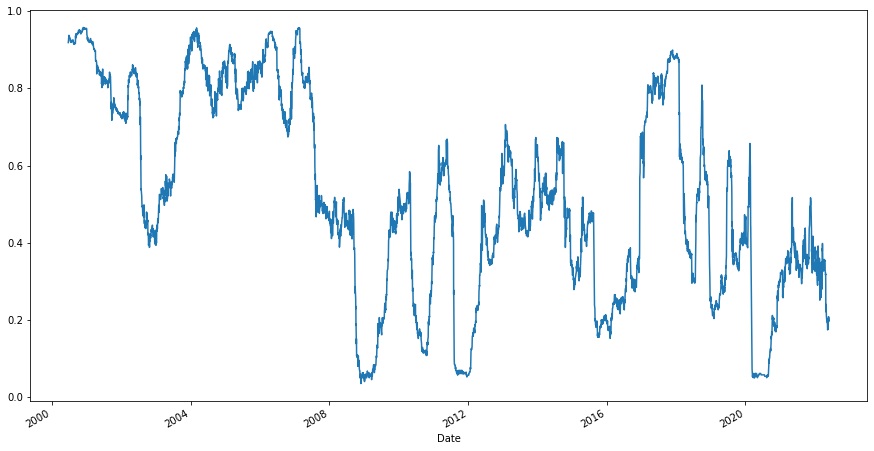

In [9]:
entropy_df['120'].plot(figsize=(15, 8))

<AxesSubplot:xlabel='Date'>

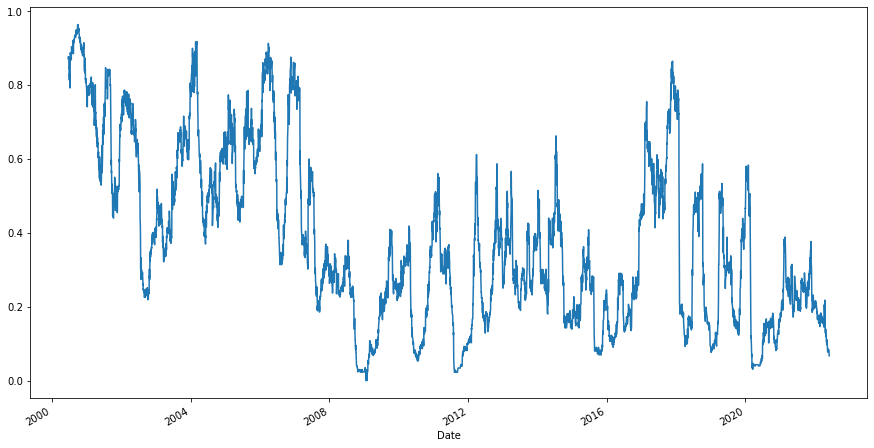

In [10]:
entropy_df['60'].plot(figsize=(15, 8))

## Entropy cross section

It was observed that entropy over window length 120 moves slower than entropy over window 60. As such, we believe we can try to capture the trend of entropy and hence take the differences across different window lengths and calculate the mean of this cross sectional difference and its standard deviation. Remember, it is a a cross sectional difference, i.e. the difference across entropies for each window size for a given day.

In [11]:
entropy_cross_section_sd = entropy_df.diff(axis=1).dropna(axis=1).std(axis=1)
entropy_cross_section_sd.name = 'entropy_sd'

entropy_cross_section_mean = entropy_df.diff(axis=1).dropna(axis=1).mean(axis=1)
entropy_cross_section_mean.name = 'entropy_mean'

##### How does the plot of entropy cross sectional mean look like?

<AxesSubplot:xlabel='Date'>

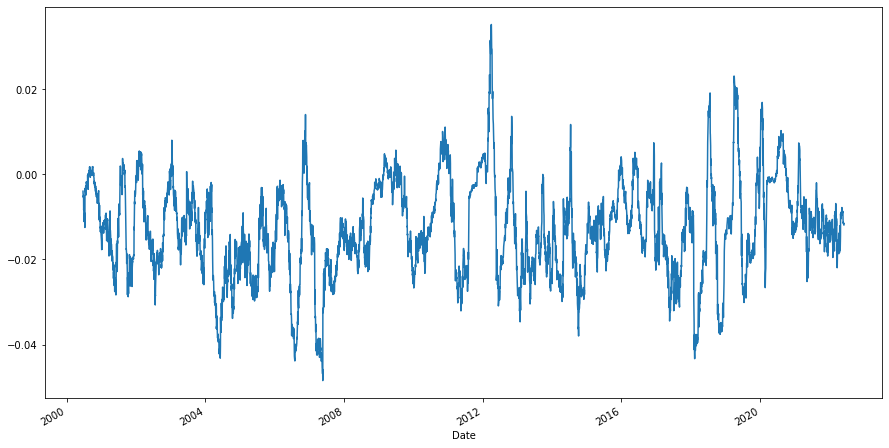

In [12]:
entropy_cross_section_mean.plot(figsize=(15, 8))

##### How does entropy cross sectional standard deviation look like?

<AxesSubplot:xlabel='Date'>

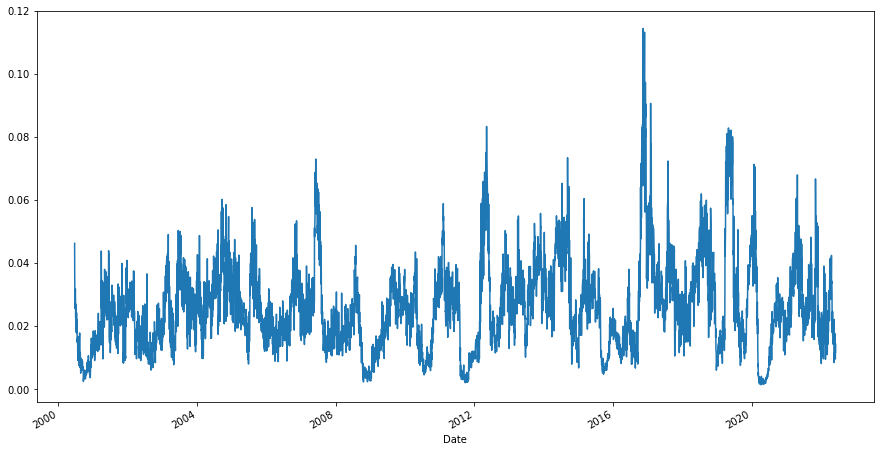

In [13]:
entropy_cross_section_sd.plot(figsize=(15, 8))

## Wavelet Denoising Signal

The above plots show that the signals are quite noisy and we would like to denoise these signals. Among various techniques to smoothen this, this article chooses the wavelet technique to denoise these signals.

In [14]:
import pywt
def madev(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [15]:
denoise_mean_look_ahead_bias = wavelet_denoising(entropy_cross_section_mean)[1:]
denoise_mean_look_ahead_bias = pd.Series(denoise_mean_look_ahead_bias, index=entropy_cross_section_mean.index)

#### How does the denoised cross sectional average look like?

<AxesSubplot:xlabel='Date'>

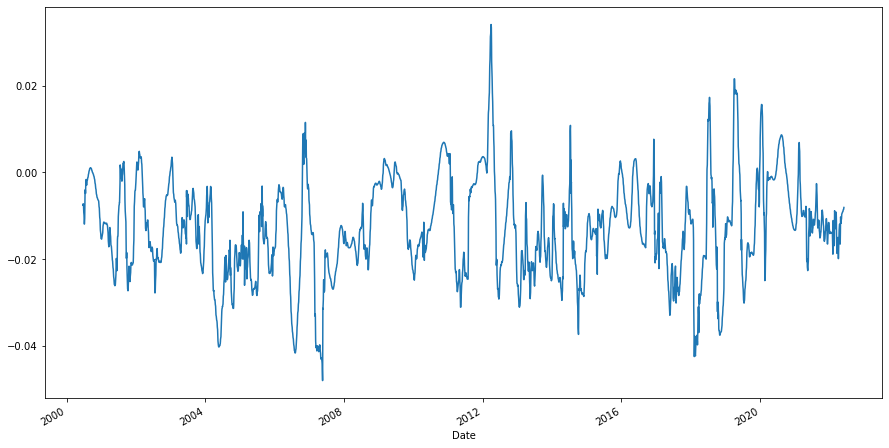

In [16]:
denoise_mean_look_ahead_bias.plot(figsize=(15, 8))

#### Similarly we denoise the cross sectional standard deviation and plot it.

<AxesSubplot:xlabel='Date'>

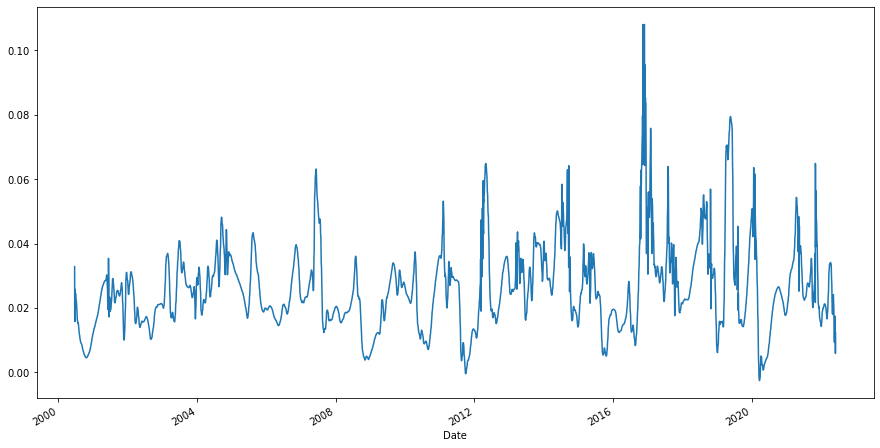

In [17]:
denoise_sd_look_ahead_bias = wavelet_denoising(entropy_cross_section_sd)[1:]
denoise_sd_look_ahead_bias = pd.Series(denoise_sd_look_ahead_bias, index=entropy_cross_section_sd.index)
denoise_sd_look_ahead_bias.plot(figsize=(15, 8))

## Eliminate look ahead bias

Since we denoised the entire signal over 22 years in one go, there is look ahead bias. 

Hence, we denoise signal and then subtract the denoised signal from original signal to get higher frequency changes over a rolling window every day using historic data to avoid forward looking.

In [18]:
Y = []
Z = []

D = entropy_cross_section_sd
E = entropy_cross_section_mean

for i in tqdm(range(300, D.shape[0])):
    X = D.iloc[i-300:i+1]
    y = wavelet_denoising(X)[1:]
    zscore = (y[-1] - np.mean(y)) / np.std(y)
    Y.append(zscore)
    
    X = E.iloc[i-300:i+1]
    y = wavelet_denoising(X)[1:]
    y = np.array(y) - X
    zscore = (y[-1] - np.mean(y)) / np.std(y)
    Z.append(zscore)
    
denoise_sd = pd.Series(Y, index=D.index[300:])
denoise_mean = pd.Series(Z, index=E.index[300:])

100%|█████████████████████████████████████| 5223/5223 [00:02<00:00, 2037.77it/s]


<AxesSubplot:xlabel='Date'>

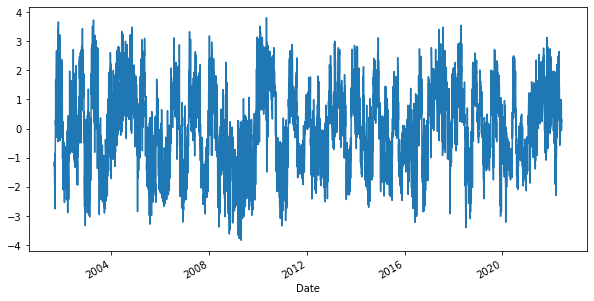

In [19]:
denoise_mean.plot(figsize=(10, 5))

<AxesSubplot:xlabel='Date'>

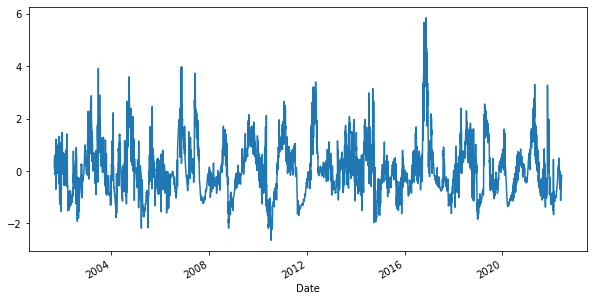

In [20]:
denoise_sd.plot(figsize=(10, 5))

### Trading Strategy

The above z-scores are our trading signals for next day. The denoise mean is used to identify the entry signal or when to start hedging and the denoise sdev is exit signal (when to stop hedging).

In [21]:
denoise_mean.name = 'entry'
denoise_sd.name = 'exit'

## Long S&P500 (SPY) - Hedge with Russell (IWM)

In the following section, we replicate a long only buy and hold SPY position. Then we use above signals to identify periods where we can hedge this with a short IWM and plot the P/L curve of both the long SPY position and secondly the entropy based SPY hedged with IWM position.

<AxesSubplot:xlabel='Date'>

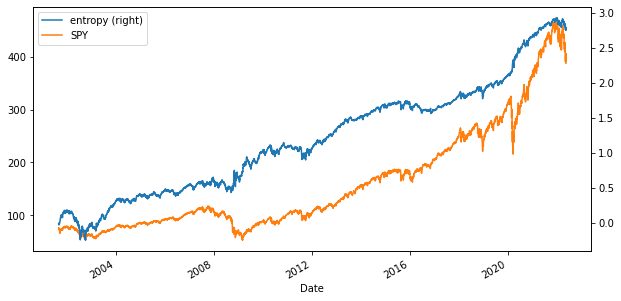

In [22]:
exit_signal = denoise_sd.ewm(span=3).mean().sub(denoise_sd.ewm(span=5).mean()).dropna()

trading_signals = pd.merge(exit_signal.to_frame(name='exit'), 
                           denoise_mean.to_frame(name='entry'), left_index=True, right_index=True).dropna()
hedge_position = [0]

for i in range(1, trading_signals.shape[0]):
    if trading_signals['entry'][i] < -2: # 2 Sigma -ve
        hedge_position.append(-1)
    elif hedge_position[-1] == -1 and (trading_signals['exit'][i] > 0):
        hedge_position.append(0)
    else:
        hedge_position.append(hedge_position[-1])

hedge_position = pd.Series(hedge_position[1:], index=trading_signals.index[1:], name="hedge_position")
pnl = hedge_position.shift(1).mul(iwm_returns, axis=0).dropna() # hedge with Russell
pnl = pnl.add(spy_returns, axis=0)
view = pd.merge(pnl.cumsum().to_frame(name='entropy'), spy, left_index=True, right_index=True).dropna()
view.plot(secondary_y='entropy', figsize=(10, 5))

## Conclusion

There appears to be some merit to this approach. Further experiments can attempt:

1. Choose a different portfolio instead of SPY.
2. Choose different hedge instruments instead of Russell 2000.
3. Decompose portfolio into sub portfolios by sector and attempt to hedge each sub portfolio by Sector ETFs.
4. Use Random matrix theory to compute structural entropy instead of a correlation cutoff (e.g. 0.6).
5. Explore other denoising techniques.